In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from functools import reduce

/Users/michael-tu/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [239]:
import keras
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Activation, Dropout, BatchNormalization, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D
from keras.layers import SimpleRNN, RNN, LSTM, Embedding, Bidirectional
from keras.optimizers import Adam, SGD
import keras.utils as utils

In [339]:
from generate_data import viterbi_decode_sequences

# Utility Functions

In [3]:
def load_pkl(path):
    return pickle.load(open(path, "rb"))

In [468]:
def load_data(data):
    keys = ['message_seqs', 'encoded_seqs', 'noisy_seqs', 'viterbi_decoded_seqs']
    x = data[keys[2]] # noisy sequences will be our input to our models
    y = data[keys[0]]
    y_viterbi_decoded = data[keys[3]]
    
    x = np.array(x)
    y = np.array(y)
    y_viterbi_decoded = np.array(y_viterbi_decoded)
    
    return x, y, y_viterbi_decoded

In [469]:
def load(path):
    return load_data(load_pkl(path))

In [470]:
def load_pkl_paths_from_folder(dir_path, recursive=False):
    if recursive:
        return np.sort(list(filter(lambda x: ".pkl" in x,
                            [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(dir_path)) 
                                                 for f in fn])))
    else:
        return np.sort([dir_path + "/" + x for x in os.listdir(dir_path) if ".pkl" in x ])

In [471]:
def get_param_from_filename(filename, param):
    split_token = "_"
    if param == "k":
        split_token = "_k"
    elif param == "p":
        split_token = "_p"
    elif param == "r":
        split_token = "_r"
    elif param == "l":
        split_token = "_l"
    elif param == "e":
        split_token = "_e"
    elif param == "n":
        split_token = "_n"
    else:
        raise ValueError("unrecognized parameter", param)
        
    res = filename.split("/")[-1].split(split_token)[1].split("_")[0]
    if ".pkl" in res:
        res = res.split(".pkl")[0]
    
    return float(res)

# Data Processing

In [473]:
def train_test_split(x, y, test_ratio=0.2):
    indicies = np.arange(len(x))
    np.random.shuffle(indicies)
    
    split_inx = int(len(x) * (1-test_ratio))
    X_train, X_test = x[indicies[:split_inx]], x[indicies[split_inx:]]
    y_train, y_test = y[indicies[:split_inx]], y[indicies[split_inx:]]
    
    
    return X_train, X_test, y_train, y_test

In [9]:
def group_sort(benchmark, *args):
    sorted_indicies = np.argsort(benchmark) 
    
    benchmark = np.array(benchmark)
    args = list(map(lambda x: np.array(x), args))
    
    benchmark_sorted = benchmark[sorted_indicies]
    args_sorted = list(map(lambda x: x[sorted_indicies], args))
    
    return benchmark_sorted, args_sorted

In [10]:
def one_hot(data):
    res = []
    for d in data:
        res.append([0,0])
        res[-1][int(d)] = 1
    return np.array(res)

def one_hot_datasets(y):
    return np.array(list(map(lambda x: one_hot(x), y)))

def onehot_to_normal(dataset):
    return np.argmax(dataset, axis=2)

In [11]:
variable_desc = {
    "k": "message length (K-bit)",
    "p": "prob P of Bernoulli distribution",
    "e": "corruption probability E",
    "l": "constraint length L"
}

In [474]:
def build_data_from_path(path, test_ratio=0.2, X_reshape=None):
    X, y, y_viterbi_decoded = load(path)
        
    y_oh = one_hot_datasets(y)
    
    if X_reshape:
        total_shape = np.product(X_reshape[1:])
        if total_shape != X.shape[1]:
            X = X[:,:total_shape]
        X = X.reshape(X_reshape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_oh, test_ratio=test_ratio)
    
    return (X_train, y_train), (X_test, y_test), (X, y, y_oh, y_viterbi_decoded)

In [206]:
def prepare_data_for_lstm(X_train, seq_length=3):
    X_train2 = list()
    for x in X_train:
        x2 = list()
        for i in range(0, len(x) - seq_length, 1):
            x2.append(x[i:i+seq_length])
        X_train2.append(np.array(x2))
    X_train2 = np.array(X_train2)
    return X_train2

# Evaluation Metrics

In [22]:
def accuracy(y, y_pred, argmax=False, viterbi=False):
    y_pred_binary = y_pred
    
    if viterbi:
        y_pred_binary = [p[:y.shape[1]] for p in y_pred]
    elif argmax:
        y_pred_binary = np.vstack([np.argmax(p, axis=1) for p in y_pred])
        assert y.shape == y_pred_binary.shape, "prediction and ground truth must \
        have same shape\nExpected:{0} Actual:{1}".format(y.shape, y_pred_binary.shape)
    
    return np.sum(y == y_pred_binary) / np.product(y.shape)

In [23]:
def model_accuracy(model, x, y, argmax=False):
    if argmax:
        y_pred = model.predict(x)
        return accuracy(y, y_pred, argmax)
    else:
        return model.evaluate(x, y, verbose=0)[1]

In [24]:
def pred_vs_truth(model, x, y, n_show=2, y_truth_is_onehot=False):
    indicies = np.random.randint(low=0, high=x.shape[0], size=n_show)
    y_pred = model.predict(x[indicies])
    y_pred_binary = np.vstack([np.argmax(p, axis=1) for p in y_pred])
    
    truth = y[indicies].astype(y_pred_binary.dtype)
    
    if y_truth_is_onehot:
        truth = onehot_to_normal(truth)
    
    for i in range(len(truth)):
        print("\n############## Example {0} ##############".format(i))
        print("Expected:\n", truth[i])
        print("Actual:\n", y_pred_binary[i])

# Graph

In [25]:
def plot_acc(title, acc):
    epoch = np.arange(1,len(acc)+1,1)
    
    plt.figure(figsize=(20,6))

    plt.subplot(121)
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel("accuracy")
    plt.plot(epoch, acc, "green")

    plt.subplot(122)
    plt.title("Log Log {0}".format(title))
    plt.xlabel('epoch')
    plt.ylabel("accuracy")
    plt.plot(epoch, np.log(-np.log(acc)), "red")

# Experiments

### k: 10, e: 0.05

In [419]:
train, test, original = build_data_from_path("../data/dataset_04/data/dataset_n25000_k10_e0.05.pkl")
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

In [420]:
print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(20000, 24)
(5000, 24)

(20000, 10, 2)
(5000, 10, 2)


**Viterbi**

In [424]:
y_test_viterbi = one_hot_datasets(np.array(viterbi_decode_sequences(X_test, L=3)))

In [425]:
accuracy(y_test, y_test_viterbi, viterbi=True)

0.99428

**FNN**

In [330]:
model = Sequential()

model.add(Dense(128, activation="relu", input_shape=X_train.shape[1:], 
                kernel_regularizer=regularizers.l2(0.00001)))
model.add(Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.00001)))
model.add(Dense(480, activation="relu", kernel_regularizer=regularizers.l2(0.00001)))

model.add(Dense(np.product(y_train.shape[1:]), activation="sigmoid"))
model.add(Reshape(y_train.shape[1:]))

In [331]:
opt = Adam(lr=0.01)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [332]:
fnn_k10_elow_history = model.fit(X_train, y_train, batch_size=256, epochs=30, 
                                 shuffle=True, verbose=2, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
 - 4s - loss: 0.3711 - acc: 0.7985 - val_loss: 0.2249 - val_acc: 0.9038
Epoch 2/30
 - 0s - loss: 0.1512 - acc: 0.9462 - val_loss: 0.1144 - val_acc: 0.9641
Epoch 3/30
 - 0s - loss: 0.0911 - acc: 0.9728 - val_loss: 0.0967 - val_acc: 0.9714
Epoch 4/30
 - 0s - loss: 0.0699 - acc: 0.9817 - val_loss: 0.0836 - val_acc: 0.9777
Epoch 5/30
 - 0s - loss: 0.0620 - acc: 0.9845 - val_loss: 0.0801 - val_acc: 0.9789
Epoch 6/30
 - 0s - loss: 0.0555 - acc: 0.9866 - val_loss: 0.0804 - val_acc: 0.9792
Epoch 7/30
 - 0s - loss: 0.0510 - acc: 0.9885 - val_loss: 0.0846 - val_acc: 0.9789
Epoch 8/30
 - 0s - loss: 0.0489 - acc: 0.9892 - val_loss: 0.0839 - val_acc: 0.9789
Epoch 9/30
 - 0s - loss: 0.0476 - acc: 0.9898 - val_loss: 0.0810 - val_acc: 0.9803
Epoch 10/30
 - 0s - loss: 0.0452 - acc: 0.9910 - val_loss: 0.0811 - val_acc: 0.9815
Epoch 11/30
 - 0s - loss: 0.0432 - acc: 0.9914 - val_loss: 0.0820 - val_acc: 0.9809
Epoch 12/30
 - 1s - loss: 0.0444 - a

In [333]:
model_accuracy(model, X_test, y_test, argmax=False)

0.981689998626709

**CNN**

In [155]:
print(X_train.shape)
print(X_test.shape)

(20000, 24)
(5000, 24)


In [159]:
X_train_cnn = X_train.reshape([-1, 6, 4])
X_test_cnn = X_test.reshape([-1, 6, 4])

In [160]:
print(X_train_cnn.shape)
print(X_test_cnn.shape)

(20000, 6, 4)
(5000, 6, 4)


In [184]:
model = Sequential()

model.add(Conv1D(filters=120, kernel_size=3, strides=1, padding="same", 
                 activation="relu", input_shape=X_train_cnn.shape[1:]))

model.add(Conv1D(filters=120, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(Conv1D(filters=120, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(Conv1D(filters=120, kernel_size=3, strides=1, padding="same", activation="relu"))

# no dropout seems to do well

model.add(Flatten())

model.add(Dense(512, activation="relu"))
model.add(Dense(256, activation="relu"))

model.add(Dense(np.product(y_train.shape[1:]), activation="sigmoid"))
model.add(Reshape(y_train.shape[1:]))

In [185]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [186]:
cnn_k10_elow_history = model.fit(X_train_cnn, y_train, batch_size=256, epochs=30, 
                                 shuffle=True, verbose=2, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
 - 3s - loss: 0.4421 - acc: 0.7622 - val_loss: 0.1832 - val_acc: 0.9330
Epoch 2/30
 - 2s - loss: 0.1187 - acc: 0.9572 - val_loss: 0.0845 - val_acc: 0.9688
Epoch 3/30
 - 2s - loss: 0.0699 - acc: 0.9754 - val_loss: 0.0677 - val_acc: 0.9754
Epoch 4/30
 - 2s - loss: 0.0541 - acc: 0.9816 - val_loss: 0.0614 - val_acc: 0.9783
Epoch 5/30
 - 2s - loss: 0.0457 - acc: 0.9839 - val_loss: 0.0500 - val_acc: 0.9821
Epoch 6/30
 - 2s - loss: 0.0405 - acc: 0.9856 - val_loss: 0.0576 - val_acc: 0.9788
Epoch 7/30
 - 2s - loss: 0.0366 - acc: 0.9871 - val_loss: 0.0498 - val_acc: 0.9825
Epoch 8/30
 - 2s - loss: 0.0330 - acc: 0.9881 - val_loss: 0.0486 - val_acc: 0.9825
Epoch 9/30
 - 2s - loss: 0.0285 - acc: 0.9900 - val_loss: 0.0474 - val_acc: 0.9837
Epoch 10/30
 - 2s - loss: 0.0263 - acc: 0.9905 - val_loss: 0.0469 - val_acc: 0.9838
Epoch 11/30
 - 2s - loss: 0.0243 - acc: 0.9914 - val_loss: 0.0446 - val_acc: 0.9848
Epoch 12/30
 - 2s - loss: 0.0201 - a

In [192]:
model_accuracy(model, X_test_cnn, y_test, argmax=False)

0.9854899982452393

**LSTM**

In [354]:
X_train_lstm = prepare_data_for_lstm(X_train)
X_test_lstm = prepare_data_for_lstm(X_test)

In [355]:
print(X_train_lstm.shape)
print(X_test_lstm.shape)

(20000, 21, 3)
(5000, 21, 3)


In [252]:
lr = 0.01
model = Sequential()

model.add(LSTM(200, activation="tanh", input_shape=(21, 3), return_sequences=False))

model.add(Dense(128, activation="relu"))

model.add(Dense(20, activation="sigmoid"))
model.add(Reshape((10,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

lstm_k10_elow_history = model.fit(X_train_lstm, y_train, epochs=30, batch_size=256, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
 - 10s - loss: 0.5604 - acc: 0.6381 - val_loss: 0.4437 - val_acc: 0.7581
Epoch 2/30
 - 6s - loss: 0.3368 - acc: 0.8297 - val_loss: 0.2399 - val_acc: 0.8947
Epoch 3/30
 - 6s - loss: 0.1543 - acc: 0.9387 - val_loss: 0.1055 - val_acc: 0.9633
Epoch 4/30
 - 7s - loss: 0.0817 - acc: 0.9716 - val_loss: 0.0851 - val_acc: 0.9703
Epoch 5/30
 - 6s - loss: 0.0609 - acc: 0.9787 - val_loss: 0.0688 - val_acc: 0.9768
Epoch 6/30
 - 7s - loss: 0.0477 - acc: 0.9834 - val_loss: 0.0625 - val_acc: 0.9789
Epoch 7/30
 - 7s - loss: 0.0391 - acc: 0.9858 - val_loss: 0.0639 - val_acc: 0.9786
Epoch 8/30
 - 7s - loss: 0.0343 - acc: 0.9877 - val_loss: 0.0677 - val_acc: 0.9793
Epoch 9/30
 - 6s - loss: 0.0310 - acc: 0.9889 - val_loss: 0.0608 - val_acc: 0.9797
Epoch 10/30
 - 6s - loss: 0.0276 - acc: 0.9897 - val_loss: 0.0652 - val_acc: 0.9819
Epoch 11/30
 - 7s - loss: 0.0226 - acc: 0.9918 - val_loss: 0.0625 - val_acc: 0.9817
Epoch 12/30
 - 8s - loss: 0.0205 - 

In [254]:
model_accuracy(model, X_test_lstm, y_test, argmax=False)

0.9813200016975403

**Bidirectional LSTM**

In [356]:
print(X_train_lstm.shape)
print(X_test_lstm.shape)

(20000, 21, 3)
(5000, 21, 3)


In [357]:
lr = 0.01
model = Sequential()

model.add(Bidirectional(LSTM(200, activation="tanh", return_sequences=False), input_shape=X_train_lstm.shape[1:]))

model.add(Dense(128, activation="relu"))

model.add(Dense(20, activation="sigmoid"))
model.add(Reshape((10,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

bidir_lstm_k10_elow_history = model.fit(X_train_lstm, y_train, epochs=30, batch_size=512, 
                                        verbose=2, shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
 - 15s - loss: 0.5475 - acc: 0.6621 - val_loss: 0.4265 - val_acc: 0.7545
Epoch 2/30
 - 10s - loss: 0.3234 - acc: 0.8353 - val_loss: 0.2158 - val_acc: 0.9068
Epoch 3/30
 - 11s - loss: 0.1460 - acc: 0.9433 - val_loss: 0.1086 - val_acc: 0.9594
Epoch 4/30
 - 10s - loss: 0.0829 - acc: 0.9696 - val_loss: 0.0745 - val_acc: 0.9731
Epoch 5/30
 - 10s - loss: 0.0569 - acc: 0.9797 - val_loss: 0.0585 - val_acc: 0.9796
Epoch 6/30
 - 13s - loss: 0.0406 - acc: 0.9854 - val_loss: 0.0544 - val_acc: 0.9802
Epoch 7/30
 - 11s - loss: 0.0338 - acc: 0.9878 - val_loss: 0.0496 - val_acc: 0.9824
Epoch 8/30
 - 10s - loss: 0.0272 - acc: 0.9902 - val_loss: 0.0424 - val_acc: 0.9852
Epoch 9/30
 - 10s - loss: 0.0219 - acc: 0.9922 - val_loss: 0.0439 - val_acc: 0.9854
Epoch 10/30
 - 12s - loss: 0.0176 - acc: 0.9937 - val_loss: 0.0479 - val_acc: 0.9846
Epoch 11/30
 - 12s - loss: 0.0166 - acc: 0.9941 - val_loss: 0.0476 - val_acc: 0.9860
Epoch 12/30
 - 10s - loss

In [358]:
model_accuracy(model, X_test_lstm, y_test, argmax=False)

0.9844800001144409

**Plots**

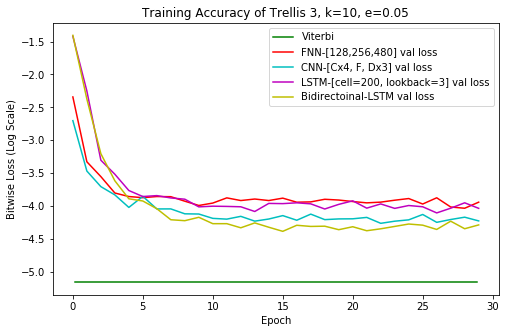

In [426]:
plt.figure(figsize=(8, 5))
plt.title('Training Accuracy of Trellis 3, k=10, e=0.05')

plt.axhline(np.log(1 - 0.99428), color="green", xmin=0.05, xmax=0.95, label="Viterbi")

plt.plot(np.log(1 - np.array(fnn_k10_elow_history.history['val_acc'])), 'r-', label="FNN-[128,256,480] val loss")
plt.plot(np.log(1 - np.array(cnn_k10_elow_history.history['val_acc'])), 'c-', label="CNN-[Cx4, F, Dx3] val loss")
plt.plot(np.log(1 - np.array(lstm_k10_elow_history.history['val_acc'])), 'm-', label="LSTM-[cell=200, lookback=3] val loss")
plt.plot(np.log(1 - np.array(bidir_lstm_k10_elow_history.history['val_acc'])), 'y-', label="Bidirectoinal-LSTM val loss")

plt.ylabel('Bitwise Loss (Log Scale)')
plt.xlabel('Epoch')

plt.legend()
plt.show()

### k10, e0.15

In [489]:
train, test, original = build_data_from_path("../data/dataset_04/data/dataset_n25000_k10_e0.15.pkl")
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

In [490]:
print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)
print()

(20000, 36)
(5000, 36)

(20000, 10, 2)
(5000, 10, 2)



**Viterbi**

In [492]:
accuracy(y, y_viterbi_decoded, viterbi=True)

0.937168

**FNN**

In [503]:
model = Sequential()

model.add(Dense(128, activation="relu", input_shape=X_train.shape[1:], 
                kernel_regularizer=regularizers.l2(0.00001)))
model.add(Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.00001)))
model.add(Dense(480, activation="relu", kernel_regularizer=regularizers.l2(0.00001)))

model.add(Dense(np.product(y_train.shape[1:]), activation="sigmoid"))
model.add(Reshape(y_train.shape[1:]))

opt = Adam(lr=0.01)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [504]:
fnn_k10_ehigh_history = model.fit(X_train, y_train, batch_size=256, epochs=30, 
                                 shuffle=True, verbose=2, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
 - 4s - loss: 0.5061 - acc: 0.7023 - val_loss: 0.4212 - val_acc: 0.7737
Epoch 2/30
 - 1s - loss: 0.3798 - acc: 0.8050 - val_loss: 0.3703 - val_acc: 0.8122
Epoch 3/30
 - 1s - loss: 0.3349 - acc: 0.8394 - val_loss: 0.3359 - val_acc: 0.8514
Epoch 4/30
 - 0s - loss: 0.2896 - acc: 0.8805 - val_loss: 0.3096 - val_acc: 0.8753
Epoch 5/30
 - 0s - loss: 0.2632 - acc: 0.8968 - val_loss: 0.2979 - val_acc: 0.8843
Epoch 6/30
 - 0s - loss: 0.2415 - acc: 0.9087 - val_loss: 0.2893 - val_acc: 0.8921
Epoch 7/30
 - 0s - loss: 0.2225 - acc: 0.9190 - val_loss: 0.2841 - val_acc: 0.8964
Epoch 8/30
 - 0s - loss: 0.2073 - acc: 0.9267 - val_loss: 0.2693 - val_acc: 0.9048
Epoch 9/30
 - 0s - loss: 0.1958 - acc: 0.9321 - val_loss: 0.2787 - val_acc: 0.9028
Epoch 10/30
 - 0s - loss: 0.1863 - acc: 0.9360 - val_loss: 0.2841 - val_acc: 0.9020
Epoch 11/30
 - 0s - loss: 0.1803 - acc: 0.9404 - val_loss: 0.2932 - val_acc: 0.9029
Epoch 12/30
 - 0s - loss: 0.1733 - a

In [506]:
model_accuracy(model, X_test, y_test, argmax=False)

0.9013999989509582

**CNN**

In [507]:
print(X_train.shape)
print(X_test.shape)

(20000, 36)
(5000, 36)


In [508]:
X_train_cnn = X_train.reshape([-1, 6, 6])
X_test_cnn = X_test.reshape([-1, 6, 6])

print(X_train_cnn.shape)
print(X_test_cnn.shape)

(20000, 6, 6)
(5000, 6, 6)


In [509]:
model = Sequential()

model.add(Conv1D(filters=120, kernel_size=3, strides=1, padding="same", 
                 activation="relu", input_shape=X_train_cnn.shape[1:]))

model.add(Conv1D(filters=120, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(Conv1D(filters=120, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(Conv1D(filters=120, kernel_size=3, strides=1, padding="same", activation="relu"))

# no dropout seems to do well

model.add(Flatten())

model.add(Dense(512, activation="relu"))
model.add(Dense(256, activation="relu"))

model.add(Dense(np.product(y_train.shape[1:]), activation="sigmoid"))
model.add(Reshape(y_train.shape[1:]))

opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [510]:
cnn_k10_ehigh_history = model.fit(X_train_cnn, y_train, batch_size=256, epochs=30, 
                                 shuffle=True, verbose=2, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
 - 7s - loss: 0.5517 - acc: 0.6753 - val_loss: 0.4392 - val_acc: 0.7880
Epoch 2/30
 - 2s - loss: 0.3450 - acc: 0.8474 - val_loss: 0.2989 - val_acc: 0.8738
Epoch 3/30
 - 2s - loss: 0.2651 - acc: 0.8902 - val_loss: 0.2525 - val_acc: 0.8956
Epoch 4/30
 - 2s - loss: 0.2280 - acc: 0.9073 - val_loss: 0.2382 - val_acc: 0.9037
Epoch 5/30
 - 2s - loss: 0.2038 - acc: 0.9186 - val_loss: 0.2212 - val_acc: 0.9104
Epoch 6/30
 - 2s - loss: 0.1862 - acc: 0.9257 - val_loss: 0.2059 - val_acc: 0.9175
Epoch 7/30
 - 3s - loss: 0.1720 - acc: 0.9325 - val_loss: 0.2027 - val_acc: 0.9198
Epoch 8/30
 - 3s - loss: 0.1583 - acc: 0.9379 - val_loss: 0.1997 - val_acc: 0.9200
Epoch 9/30
 - 2s - loss: 0.1470 - acc: 0.9425 - val_loss: 0.1987 - val_acc: 0.9230
Epoch 10/30
 - 2s - loss: 0.1357 - acc: 0.9471 - val_loss: 0.2013 - val_acc: 0.9224
Epoch 11/30
 - 2s - loss: 0.1280 - acc: 0.9500 - val_loss: 0.1983 - val_acc: 0.9233
Epoch 12/30
 - 2s - loss: 0.1170 - a

In [511]:
model_accuracy(model, X_test_cnn, y_test, argmax=False)

0.9159599994659424

**LSTM**

In [512]:
X_train_lstm = prepare_data_for_lstm(X_train)
X_test_lstm = prepare_data_for_lstm(X_test)

print(X_train_lstm.shape)
print(X_test_lstm.shape)

(20000, 33, 3)
(5000, 33, 3)


In [513]:
lr = 0.01
model = Sequential()

model.add(LSTM(200, activation="tanh", input_shape=(33, 3), return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(40, activation="relu"))

model.add(Dense(20, activation="sigmoid"))
model.add(Reshape((10, 2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [514]:
lstm_k10_ehigh_history = model.fit(X_train_lstm, y_train, epochs=30, batch_size=256, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
 - 16s - loss: 0.6291 - acc: 0.5791 - val_loss: 0.5802 - val_acc: 0.6159
Epoch 2/30
 - 11s - loss: 0.5708 - acc: 0.6272 - val_loss: 0.5492 - val_acc: 0.6500
Epoch 3/30
 - 12s - loss: 0.5452 - acc: 0.6532 - val_loss: 0.5230 - val_acc: 0.6703
Epoch 4/30
 - 11s - loss: 0.5163 - acc: 0.6853 - val_loss: 0.4827 - val_acc: 0.7137
Epoch 5/30
 - 11s - loss: 0.4834 - acc: 0.7205 - val_loss: 0.4526 - val_acc: 0.7438
Epoch 6/30
 - 11s - loss: 0.4433 - acc: 0.7634 - val_loss: 0.4118 - val_acc: 0.7933
Epoch 7/30
 - 15s - loss: 0.3919 - acc: 0.8077 - val_loss: 0.3357 - val_acc: 0.8434
Epoch 8/30
 - 14s - loss: 0.3425 - acc: 0.8409 - val_loss: 0.2964 - val_acc: 0.8691
Epoch 9/30
 - 11s - loss: 0.2981 - acc: 0.8716 - val_loss: 0.2564 - val_acc: 0.8936
Epoch 10/30
 - 11s - loss: 0.2601 - acc: 0.8913 - val_loss: 0.2220 - val_acc: 0.9149
Epoch 11/30
 - 10s - loss: 0.2296 - acc: 0.9086 - val_loss: 0.2171 - val_acc: 0.9188
Epoch 12/30
 - 10s - loss

In [515]:
model_accuracy(model, X_test_lstm, y_test, argmax=False)

0.9138699984550476

**Bidirectoinal LSTM**

In [520]:
lr = 0.01
model = Sequential()

model.add(Bidirectional(LSTM(200, activation="tanh", return_sequences=False), input_shape=X_train_lstm.shape[1:]))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))

model.add(Dense(20, activation="sigmoid"))
model.add(Reshape((10,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

bidir_lstm_k10_ehigh_history = model.fit(X_train_lstm, y_train, epochs=30, batch_size=512, 
                                        verbose=2, shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
 - 22s - loss: 0.5990 - acc: 0.6161 - val_loss: 0.5178 - val_acc: 0.6893
Epoch 2/30
 - 16s - loss: 0.4922 - acc: 0.7101 - val_loss: 0.4553 - val_acc: 0.7368
Epoch 3/30
 - 17s - loss: 0.4375 - acc: 0.7550 - val_loss: 0.4125 - val_acc: 0.7790
Epoch 4/30
 - 21s - loss: 0.4050 - acc: 0.7879 - val_loss: 0.3808 - val_acc: 0.8058
Epoch 5/30
 - 17s - loss: 0.3710 - acc: 0.8179 - val_loss: 0.3476 - val_acc: 0.8330
Epoch 6/30
 - 19s - loss: 0.3389 - acc: 0.8406 - val_loss: 0.3085 - val_acc: 0.8583
Epoch 7/30
 - 17s - loss: 0.3053 - acc: 0.8620 - val_loss: 0.2901 - val_acc: 0.8722
Epoch 8/30
 - 20s - loss: 0.2874 - acc: 0.8728 - val_loss: 0.2709 - val_acc: 0.8831
Epoch 9/30
 - 19s - loss: 0.2647 - acc: 0.8846 - val_loss: 0.2628 - val_acc: 0.8864
Epoch 10/30
 - 18s - loss: 0.2447 - acc: 0.8950 - val_loss: 0.2308 - val_acc: 0.9015
Epoch 11/30
 - 16s - loss: 0.2329 - acc: 0.9002 - val_loss: 0.2311 - val_acc: 0.9029
Epoch 12/30
 - 16s - loss

In [521]:
model_accuracy(model, X_test_lstm, y_test, argmax=False)

0.9134000004768371

**Plots**

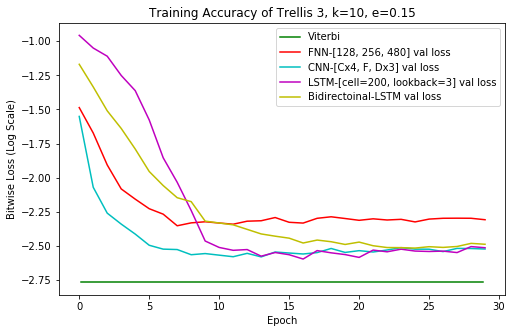

In [522]:
plt.figure(figsize=(8, 5))
plt.title('Training Accuracy of Trellis 3, k=10, e=0.15')

plt.axhline(np.log(1 - 0.937168), color="green", xmin=0.05, xmax=0.95, label="Viterbi")

plt.plot(np.log(1 - np.array(fnn_k10_ehigh_history.history['val_acc'])), 'r-', label="FNN-[128, 256, 480] val loss")
plt.plot(np.log(1 - np.array(cnn_k10_ehigh_history.history['val_acc'])), 'c-', label="CNN-[Cx4, F, Dx3] val loss")
plt.plot(np.log(1 - np.array(lstm_k10_ehigh_history.history['val_acc'])), 'm-', label="LSTM-[cell=200, lookback=3] val loss")
plt.plot(np.log(1 - np.array(bidir_lstm_k10_ehigh_history.history['val_acc'])), 'y-', label="Bidirectoinal-LSTM val loss")

plt.ylabel('Bitwise Loss (Log Scale)')
plt.xlabel('Epoch')

plt.legend()
plt.show()

### k40, e0.05

In [523]:
train, test, original = build_data_from_path("../data/dataset_04/data/dataset_n25000_k40_e0.05.pkl")
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

In [524]:
print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(20000, 84)
(5000, 84)

(20000, 40, 2)
(5000, 40, 2)


**Viterbi**

In [525]:
accuracy(y, y_viterbi_decoded, viterbi=True)

0.991822

**FNN**

In [645]:
model = Sequential()

model.add(Dense(256, activation="relu", input_shape=X_train.shape[1:], 
                kernel_regularizer=regularizers.l2(0.00001)))
model.add(Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.00001)))
model.add(Dense(768, activation="relu", kernel_regularizer=regularizers.l2(0.00001)))

model.add(Dense(np.product(y_train.shape[1:]), activation="sigmoid"))
model.add(Reshape(y_train.shape[1:]))

opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [646]:
fnn_k40_elow_history = model.fit(X_train, y_train, batch_size=200, epochs=40, 
                                 shuffle=True, verbose=2, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/40
 - 8s - loss: 0.6685 - acc: 0.5454 - val_loss: 0.6468 - val_acc: 0.5631
Epoch 2/40
 - 1s - loss: 0.6315 - acc: 0.5862 - val_loss: 0.6187 - val_acc: 0.5911
Epoch 3/40
 - 1s - loss: 0.6010 - acc: 0.6116 - val_loss: 0.5985 - val_acc: 0.6025
Epoch 4/40
 - 1s - loss: 0.5835 - acc: 0.6317 - val_loss: 0.5837 - val_acc: 0.6246
Epoch 5/40
 - 1s - loss: 0.5604 - acc: 0.6674 - val_loss: 0.5559 - val_acc: 0.6740
Epoch 6/40
 - 2s - loss: 0.4995 - acc: 0.7406 - val_loss: 0.4669 - val_acc: 0.7656
Epoch 7/40
 - 1s - loss: 0.4198 - acc: 0.8074 - val_loss: 0.4139 - val_acc: 0.8136
Epoch 8/40
 - 1s - loss: 0.3669 - acc: 0.8514 - val_loss: 0.3721 - val_acc: 0.8545
Epoch 9/40
 - 1s - loss: 0.3286 - acc: 0.8786 - val_loss: 0.3456 - val_acc: 0.8748
Epoch 10/40
 - 1s - loss: 0.3095 - acc: 0.8884 - val_loss: 0.3356 - val_acc: 0.8817
Epoch 11/40
 - 1s - loss: 0.2956 - acc: 0.8957 - val_loss: 0.3262 - val_acc: 0.8899
Epoch 12/40
 - 1s - loss: 0.2833 - a

In [647]:
model_accuracy(model, X_test, y_test, argmax=False)

0.9206324983596802

**CNN**

In [598]:
print(X_train.shape)
print(X_test.shape)

(20000, 84)
(5000, 84)


In [599]:
X_train_cnn = X_train.reshape([-1, 6, 14])
X_test_cnn = X_test.reshape([-1, 6, 14])

print(X_train_cnn.shape)
print(X_test_cnn.shape)

(20000, 6, 14)
(5000, 6, 14)


In [636]:
model = Sequential()

model.add(Conv1D(filters=240, kernel_size=3, strides=1, padding="same", 
                 activation="relu", input_shape=X_train_cnn.shape[1:]))

model.add(Conv1D(filters=240, kernel_size=3, strides=1, padding="same", activation="relu"))

model.add(Conv1D(filters=240, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(Conv1D(filters=240, kernel_size=3, strides=1, padding="same", activation="relu"))

# no dropout seems to do well

model.add(Flatten())

model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))

model.add(Dense(np.product(y_train.shape[1:]), activation="sigmoid"))
model.add(Reshape(y_train.shape[1:]))

opt = Adam(lr=0.002)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [637]:
cnn_k40_elow_history = model.fit(X_train_cnn, y_train, batch_size=256, epochs=40, 
                                 shuffle=True, verbose=2, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/40
 - 13s - loss: 0.6605 - acc: 0.5376 - val_loss: 0.6330 - val_acc: 0.5691
Epoch 2/40
 - 7s - loss: 0.5873 - acc: 0.6201 - val_loss: 0.5582 - val_acc: 0.6528
Epoch 3/40
 - 7s - loss: 0.5152 - acc: 0.7009 - val_loss: 0.4693 - val_acc: 0.7467
Epoch 4/40
 - 6s - loss: 0.4109 - acc: 0.7895 - val_loss: 0.3785 - val_acc: 0.8076
Epoch 5/40
 - 6s - loss: 0.3152 - acc: 0.8422 - val_loss: 0.2913 - val_acc: 0.8539
Epoch 6/40
 - 6s - loss: 0.2482 - acc: 0.8771 - val_loss: 0.2599 - val_acc: 0.8757
Epoch 7/40
 - 6s - loss: 0.2038 - acc: 0.9017 - val_loss: 0.2423 - val_acc: 0.8881
Epoch 8/40
 - 6s - loss: 0.1749 - acc: 0.9154 - val_loss: 0.2329 - val_acc: 0.8936
Epoch 9/40
 - 6s - loss: 0.1526 - acc: 0.9261 - val_loss: 0.2255 - val_acc: 0.9008
Epoch 10/40
 - 6s - loss: 0.1308 - acc: 0.9398 - val_loss: 0.2255 - val_acc: 0.9148
Epoch 11/40
 - 6s - loss: 0.0972 - acc: 0.9625 - val_loss: 0.1978 - val_acc: 0.9350
Epoch 12/40
 - 6s - loss: 0.0689 - 

In [638]:
model_accuracy(model, X_test_cnn, y_test, argmax=False)

0.9461899981498718

**LSTM**

In [653]:
X_train_lstm = prepare_data_for_lstm(X_train)
X_test_lstm = prepare_data_for_lstm(X_test)

print(X_train_lstm.shape)
print(X_test_lstm.shape)

(20000, 81, 3)
(5000, 81, 3)


In [675]:
lr = 0.001
model = Sequential()

model.add(LSTM(200, activation="tanh", input_shape=(81, 3), return_sequences=False))

model.add(Dense(256, activation="relu"))

model.add(Dense(80, activation="sigmoid"))
model.add(Reshape((40, 2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [676]:
lstm_k40_elow_history = model.fit(X_train_lstm, y_train, epochs=40, batch_size=256, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/40
 - 38s - loss: 0.6883 - acc: 0.5143 - val_loss: 0.6765 - val_acc: 0.5254
Epoch 2/40
 - 27s - loss: 0.6682 - acc: 0.5288 - val_loss: 0.6629 - val_acc: 0.5340
Epoch 3/40
 - 25s - loss: 0.6548 - acc: 0.5467 - val_loss: 0.6439 - val_acc: 0.5636
Epoch 4/40
 - 25s - loss: 0.6287 - acc: 0.5878 - val_loss: 0.6151 - val_acc: 0.6084
Epoch 5/40
 - 26s - loss: 0.6008 - acc: 0.6259 - val_loss: 0.5898 - val_acc: 0.6402
Epoch 6/40
 - 26s - loss: 0.5766 - acc: 0.6540 - val_loss: 0.5703 - val_acc: 0.6602
Epoch 7/40
 - 25s - loss: 0.5539 - acc: 0.6754 - val_loss: 0.5472 - val_acc: 0.6784
Epoch 8/40
 - 25s - loss: 0.5327 - acc: 0.6942 - val_loss: 0.5244 - val_acc: 0.7015
Epoch 9/40
 - 28s - loss: 0.5131 - acc: 0.7110 - val_loss: 0.5106 - val_acc: 0.7163
Epoch 10/40
 - 30s - loss: 0.4970 - acc: 0.7239 - val_loss: 0.4937 - val_acc: 0.7267
Epoch 11/40
 - 25s - loss: 0.4816 - acc: 0.7361 - val_loss: 0.4801 - val_acc: 0.7378
Epoch 12/40
 - 26s - loss

In [677]:
model_accuracy(model, X_test_lstm, y_test, argmax=False)

0.8724624986648559

**Bidirectional LSTM**

In [667]:
lr = 0.01
model = Sequential()

model.add(Bidirectional(LSTM(200, activation="tanh", return_sequences=False), input_shape=X_train_lstm.shape[1:]))

model.add(Dense(256, activation="relu"))

model.add(Dense(80, activation="sigmoid"))
model.add(Reshape((40,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [668]:
bidir_lstm_k40_elow_history = model.fit(X_train_lstm, y_train, epochs=30, batch_size=512, 
                                        verbose=2, shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
 - 57s - loss: 0.6604 - acc: 0.5404 - val_loss: 0.6351 - val_acc: 0.5576
Epoch 2/30
 - 43s - loss: 0.6147 - acc: 0.5772 - val_loss: 0.5978 - val_acc: 0.5914
Epoch 3/30
 - 42s - loss: 0.5795 - acc: 0.6128 - val_loss: 0.5614 - val_acc: 0.6363
Epoch 4/30
 - 44s - loss: 0.5358 - acc: 0.6622 - val_loss: 0.5150 - val_acc: 0.6820
Epoch 5/30
 - 41s - loss: 0.4826 - acc: 0.7109 - val_loss: 0.4639 - val_acc: 0.7263
Epoch 6/30
 - 41s - loss: 0.4341 - acc: 0.7502 - val_loss: 0.4226 - val_acc: 0.7622
Epoch 7/30
 - 43s - loss: 0.3853 - acc: 0.7887 - val_loss: 0.3787 - val_acc: 0.7980
Epoch 8/30
 - 42s - loss: 0.3435 - acc: 0.8201 - val_loss: 0.3373 - val_acc: 0.8274
Epoch 9/30
 - 45s - loss: 0.3077 - acc: 0.8453 - val_loss: 0.3234 - val_acc: 0.8439
Epoch 10/30
 - 43s - loss: 0.2760 - acc: 0.8662 - val_loss: 0.2913 - val_acc: 0.8638
Epoch 11/30
 - 42s - loss: 0.2423 - acc: 0.8858 - val_loss: 0.2627 - val_acc: 0.8752
Epoch 12/30
 - 43s - loss

In [669]:
model_accuracy(model, X_test_lstm, y_test, argmax=False)

0.9646125000953675

**Plots**

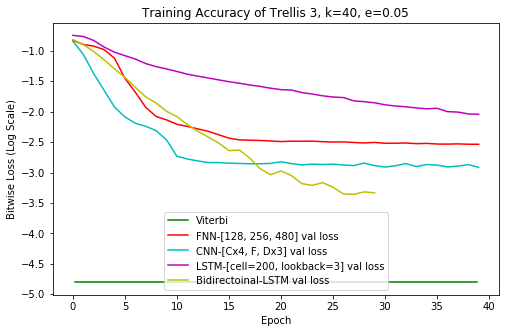

In [678]:
plt.figure(figsize=(8, 5))
plt.title('Training Accuracy of Trellis 3, k=40, e=0.05')

plt.axhline(np.log(1 - 0.991822), color="green", xmin=0.05, xmax=0.95, label="Viterbi")

plt.plot(np.log(1 - np.array(fnn_k40_elow_history.history['val_acc'])), 'r-', label="FNN-[128, 256, 480] val loss")
plt.plot(np.log(1 - np.array(cnn_k40_elow_history.history['val_acc'])), 'c-', label="CNN-[Cx4, F, Dx3] val loss")
plt.plot(np.log(1 - np.array(lstm_k40_elow_history.history['val_acc'])), 'm-', label="LSTM-[cell=200, lookback=3] val loss")
plt.plot(np.log(1 - np.array(bidir_lstm_k40_elow_history.history['val_acc'])), 'y-', label="Bidirectoinal-LSTM val loss")

plt.ylabel('Bitwise Loss (Log Scale)')
plt.xlabel('Epoch')

plt.legend()
plt.show()

### k40, e0.15

In [679]:
train, test, original = build_data_from_path("../data/dataset_04/data/dataset_n25000_k40_e0.15.pkl")
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

In [680]:
print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(20000, 126)
(5000, 126)

(20000, 40, 2)
(5000, 40, 2)


**Viterbi**

In [682]:
accuracy(y, y_viterbi_decoded, viterbi=True)

0.90785

**FNN**

In [713]:
model = Sequential()

model.add(Dense(256, activation="relu", input_shape=X_train.shape[1:], 
                kernel_regularizer=regularizers.l2(0.00001)))
model.add(Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.00001)))
model.add(Dense(768, activation="relu", kernel_regularizer=regularizers.l2(0.00001)))

model.add(Dense(np.product(y_train.shape[1:]), activation="sigmoid"))
model.add(Reshape(y_train.shape[1:]))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [714]:
fnn_k40_ehigh_history = model.fit(X_train, y_train, batch_size=256, epochs=30, 
                                 shuffle=True, verbose=2, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
 - 19s - loss: 0.7042 - acc: 0.5111 - val_loss: 0.7016 - val_acc: 0.5222
Epoch 2/30
 - 2s - loss: 0.6972 - acc: 0.5323 - val_loss: 0.6927 - val_acc: 0.5308
Epoch 3/30
 - 1s - loss: 0.6841 - acc: 0.5427 - val_loss: 0.6794 - val_acc: 0.5371
Epoch 4/30
 - 1s - loss: 0.6725 - acc: 0.5519 - val_loss: 0.6725 - val_acc: 0.5416
Epoch 5/30
 - 1s - loss: 0.6664 - acc: 0.5589 - val_loss: 0.6689 - val_acc: 0.5447
Epoch 6/30
 - 1s - loss: 0.6629 - acc: 0.5649 - val_loss: 0.6671 - val_acc: 0.5466
Epoch 7/30
 - 2s - loss: 0.6609 - acc: 0.5698 - val_loss: 0.6663 - val_acc: 0.5467
Epoch 8/30
 - 2s - loss: 0.6593 - acc: 0.5742 - val_loss: 0.6655 - val_acc: 0.5490
Epoch 9/30
 - 1s - loss: 0.6578 - acc: 0.5779 - val_loss: 0.6646 - val_acc: 0.5511
Epoch 10/30
 - 2s - loss: 0.6564 - acc: 0.5815 - val_loss: 0.6637 - val_acc: 0.5515
Epoch 11/30
 - 2s - loss: 0.6548 - acc: 0.5850 - val_loss: 0.6629 - val_acc: 0.5540
Epoch 12/30
 - 2s - loss: 0.6532 - 

In [715]:
model_accuracy(model, X_test, y_test, argmax=False)

0.5817474989891053

**CNN**

In [731]:
print(X_train.shape)
print(X_test.shape)

(20000, 126)
(5000, 126)


In [732]:
X_train_cnn = X_train.reshape([-1, 6, 21])
X_test_cnn = X_test.reshape([-1, 6, 21])

print(X_train_cnn.shape)
print(X_test_cnn.shape)

(20000, 6, 21)
(5000, 6, 21)


In [737]:
model = Sequential()

model.add(Conv1D(filters=400, kernel_size=3, strides=1, padding="same", 
                 activation="relu", input_shape=X_train_cnn.shape[1:]))

model.add(Conv1D(filters=400, kernel_size=3, strides=1, padding="same", activation="relu"))

model.add(Conv1D(filters=400, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(Conv1D(filters=400, kernel_size=3, strides=1, padding="same", activation="relu"))

# no dropout seems to do well

model.add(Flatten())

model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))

model.add(Dense(np.product(y_train.shape[1:]), activation="sigmoid"))
model.add(Reshape(y_train.shape[1:]))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [738]:
cnn_k40_ehigh_history = model.fit(X_train_cnn, y_train, batch_size=256, epochs=30, 
                                 shuffle=True, verbose=2, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
 - 50s - loss: 0.6914 - acc: 0.5166 - val_loss: 0.6841 - val_acc: 0.5239
Epoch 2/30
 - 38s - loss: 0.6700 - acc: 0.5387 - val_loss: 0.6635 - val_acc: 0.5418
Epoch 3/30
 - 44s - loss: 0.6562 - acc: 0.5533 - val_loss: 0.6561 - val_acc: 0.5495
Epoch 4/30


KeyboardInterrupt: 

In [ ]:
model_accuracy(model, X_test_cnn, y_test, argmax=False)

**LSTM**

In [ ]:
X_train_lstm = prepare_data_for_lstm(X_train)
X_test_lstm = prepare_data_for_lstm(X_test)

In [ ]:
print(X_train_lstm.shape)
print(X_test_lstm.shape)

In [ ]:
lr = 0.001
model = Sequential()

model.add(LSTM(200, activation="tanh", input_shape=(81, 3), return_sequences=False))

model.add(Dense(256, activation="relu"))

model.add(Dense(80, activation="sigmoid"))
model.add(Reshape((40, 2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
lstm_k40_ehigh_history = model.fit(X_train_lstm, y_train, epochs=30, batch_size=256, verbose=2,
          shuffle=True, validation_split=0.2)

In [ ]:
model_accuracy(model, X_test_lstm, y_test, argmax=False)

**Bidirectional LSTM**

In [ ]:
lr = 0.01
model = Sequential()

model.add(Bidirectional(LSTM(200, activation="tanh", return_sequences=False), input_shape=X_train_lstm.shape[1:]))

model.add(Dense(256, activation="relu"))

model.add(Dense(80, activation="sigmoid"))
model.add(Reshape((40,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
bidir_lstm_k40_ehigh_history = model.fit(X_train_lstm, y_train, epochs=30, batch_size=512, 
                                        verbose=2, shuffle=True, validation_split=0.2)

In [ ]:
model_accuracy(model, X_test_lstm, y_test, argmax=False)

**Plots**

In [ ]:
plt.figure(figsize=(8, 5))
plt.title('Training Accuracy of Trellis 3, k=40, e=0.15')

plt.axhline(np.log(1 - 0.90785), color="green", xmin=0.05, xmax=0.95, label="Viterbi")

plt.plot(np.log(1 - np.array(fnn_k40_ehigh_history.history['val_acc'])), 'r-', label="FNN-[128, 256, 480] val loss")
plt.plot(np.log(1 - np.array(cnn_k40_ehigh_history.history['val_acc'])), 'c-', label="CNN-[Cx4, F, Dx3] val loss")
plt.plot(np.log(1 - np.array(lstm_k40_ehigh_history.history['val_acc'])), 'm-', label="LSTM-[cell=200, lookback=3] val loss")
plt.plot(np.log(1 - np.array(bidir_lstm_k40_ehigh_history.history['val_acc'])), 'y-', label="Bidirectoinal-LSTM val loss")

plt.ylabel('Bitwise Loss (Log Scale)')
plt.xlabel('Epoch')

plt.legend()
plt.show()